# Lab 6

## Setup

This function fetches a secret from AWS Secrets Manager and returns it as a dictionary.

In [50]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

### Connect to Database

This code connects to the PostgreSQL database using credentials from Secrets Manager and creates a cursor for executing SQL commands.

In [31]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

### Set up AI

This sets up AI in Jupyter by ignoring warnings and storing the OpenAI API key for use with AI-assisted features.

In [49]:
! pip install jupyter-ai-magics[all] -q

In [48]:
import warnings
warnings.simplefilter('ignore')

In [52]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

## Q1 – Population Growth Rate

- option A: do the calculations with sql

This loads Florida’s yearly population and calculates the year-over-year growth rate into a pandas DataFrame for analysis.

In [32]:
import pandas as pd

query = """
SELECT
    year,
    pop,
    ROUND(
        ((pop::numeric - LAG(pop) OVER (ORDER BY year)) 
        / LAG(pop) OVER (ORDER BY year) * 100),
        2
    ) AS growth_rate
FROM population
WHERE fips = '12'
ORDER BY year ASC;
"""

fl_df = pd.read_sql(query, conn)
fl_df.head()


,year,pop,growth_rate
0,2005,17382511,NaN
1,2006,18089889,4.07
2,2007,18251243,0.89
3,2008,18328340,0.42
4,2009,18537969,1.14


This creates a line chart showing Florida’s annual population growth rate from 2005 to 2019.

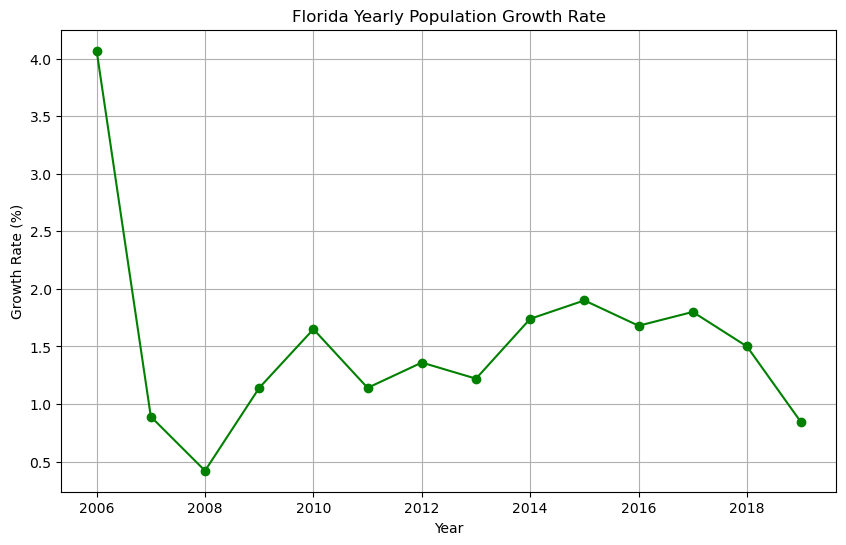

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(fl_df['year'], fl_df['growth_rate'], marker='o', color='green')
plt.title("Florida Yearly Population Growth Rate")
plt.xlabel("Year")
plt.ylabel("Growth Rate (%)")
plt.grid(True)
plt.show()


This cell uses AI to analyze Florida's population growth chart, highlighting trends and periods of faster or slower growth.

In [54]:
%%ai gpt4
Analyze the population growth chart for Florida using the data in {fl_df}. 
Explain trends, periods of faster or slower growth, and any observations.


The data presents the population growth of Florida from the year 2005 to 2019. Over these 15 years, Florida's population has progressively grown from 17,382,511 in 2005 to 21,477,737 in 2019. 

Interestingly, the year 2006 witnessed the highest annual growth rate of 4.07%. Thereafter, the growth rate dipped to 0.89% in 2007. Except for 2006, the growth rate generally fluctuates around 1.14% to 1.90%. 

Certain periods displayed faster growth while others showed slower growth. Apart from the surge in 2006, rapid growth can be observed from 2014 to 2017, where the population increased from approximately 19.9 million to 21 million. During this period, the growth rate varied between 1.68% and 1.9%.

Conversely, the slowest growth rates were recorded in the years 2008 and 2019, with growth rates of 0.42% and 0.84% respectively. Particularly, the growth rate showed a declining trend post-2017.

In summary, although the population of Florida has consistently been on an upwards trend, the growth rates have varied over these years. This indicates differing rates of migration, birth, and death rates across different periods. It's also important to note the remarkable growth between 2014 - 2017 and the subsequent decline.

**Q1 Answer:** Florida’s population grew steadily from 17.4 million in 2005 to 21.5 million in 2019, with the fastest growth in 2006 and slower growth in 2008 and 2019. Overall, growth rates fluctuated over the years but remained positive.


## Q2 – Income and Population Relationship

This cell loads Florida's population and median income data from the database into a pandas DataFrame for all years, joining the population and income tables.

In [55]:
import pandas as pd

query = """
SELECT 
    p.year,
    p.pop AS population,
    i.income AS median_income
FROM population AS p
JOIN name_income AS i
    ON p.fips = i.fips AND p.year = i.year
WHERE p.fips = '12'
ORDER BY p.year ASC;
"""

fl_df = pd.read_sql(query, conn)
fl_df.head()


,year,population,median_income
0,2005,17382511,42433
1,2006,18089889,45495
2,2007,18251243,47804
3,2008,18328340,47778
4,2009,18537969,44736


This cell creates a dual-axis chart showing Florida's population (line) on the left y-axis and median household income (bars) on the right y-axis across years 2005–2019.

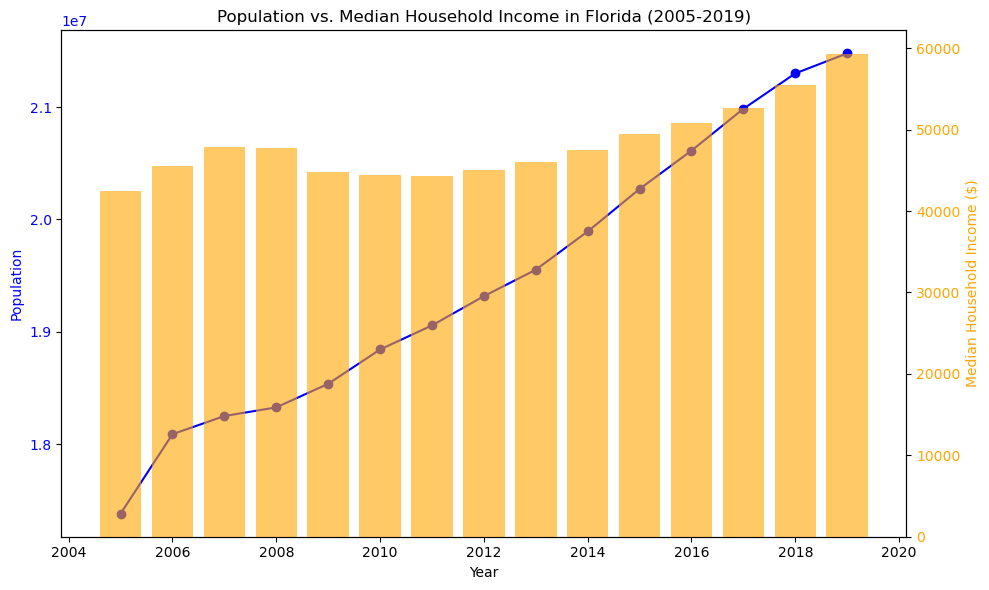

In [56]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

# Population line (left y-axis)
ax1.plot(fl_df['year'], fl_df['population'], color='blue', marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Income bar/line (right y-axis)
ax2 = ax1.twinx()
ax2.bar(fl_df['year'], fl_df['median_income'], color='orange', alpha=0.6, label='Median Income')
ax2.set_ylabel('Median Household Income ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and layout
plt.title('Population vs. Median Household Income in Florida (2005-2019)')
fig.tight_layout()
plt.show()


This cell uses Jupyter AI to analyze the Florida population and income data, describing trends and relationships between the two variables.

In [57]:
%%ai gpt4
Analyze the relationship between population and median household income in {fl_df}. 
Describe trends, periods of faster growth, and any patterns you notice.


The dataset presents the population and median household income of Florida from 2005 to 2019. Over these 15 years, both the population and median income demonstrate an upward trend—population increases from 17,382,511 in 2005 to 21,477,737 in 2019 while median income rises from approximately $42,433 to $59,227.

In terms of population, there appears to be a steady rate of growth throughout the period. The most notable surge, as mentioned before, occurs between 2014 to 2017. Conversely, the growth appears slowest in 2008 and 2019.

For median income, although the growth is generally upwards, there is some fluctuation. Income increased from $42,433 in 2005 to $47,804 in 2007, then slightly dipped in 2008 as it hits $47,778. It continues to fall until 2011 to reach $44,299. However, after this point, a consistent upward trend is visible. The growth accelerates especially after 2015 where the median annual income goes from $49,426 to $59,227 in 2019, marking a substantial growth in just four years.

While the two variables move in the same direction—increasing over time—the relationship between them is not directly proportional. While the population growth has been relatively steady throughout the 15 years, the median household income has seen periods of decrease between 2007-2011 before bouncing back and rising sharply after 2015.

In summary, while a rapid growth in population does not necessitate a similar increase in median income, as seen in the 2008-2011 phase, the data does show that over the long term, the trends for Florida’s population and median income have been positive, with the last four years (2016 - 2019) being particularly strong for income growth.

**Q2 Answer:** Over 2005–2019, Florida’s population steadily increased while median household income generally rose with some fluctuations, showing that population growth and income growth trend upward together but are not perfectly proportional.

## Q3 – Which year had the largest population increase in Florida from 2005 to 2019?

This SQL query calculates the yearly population increase in Florida by subtracting the previous year's population from the current year's population.


In [58]:
import pandas as pd

query = """
SELECT
    year,
    pop,
    LAG(pop) OVER (ORDER BY year) AS previous_year_pop,
    pop - LAG(pop) OVER (ORDER BY year) AS population_increase
FROM population
WHERE fips = '12'
ORDER BY year ASC;
"""

fl_growth_df = pd.read_sql(query, conn)
fl_growth_df.head()


,year,pop,previous_year_pop,population_increase
0,2005,17382511,NaN,NaN
1,2006,18089889,17382511.0,707378.0
2,2007,18251243,18089889.0,161354.0
3,2008,18328340,18251243.0,77097.0
4,2009,18537969,18328340.0,209629.0


This chart visualizes the annual population increase in Florida from 2005 to 2019, showing which years experienced faster or slower growth.


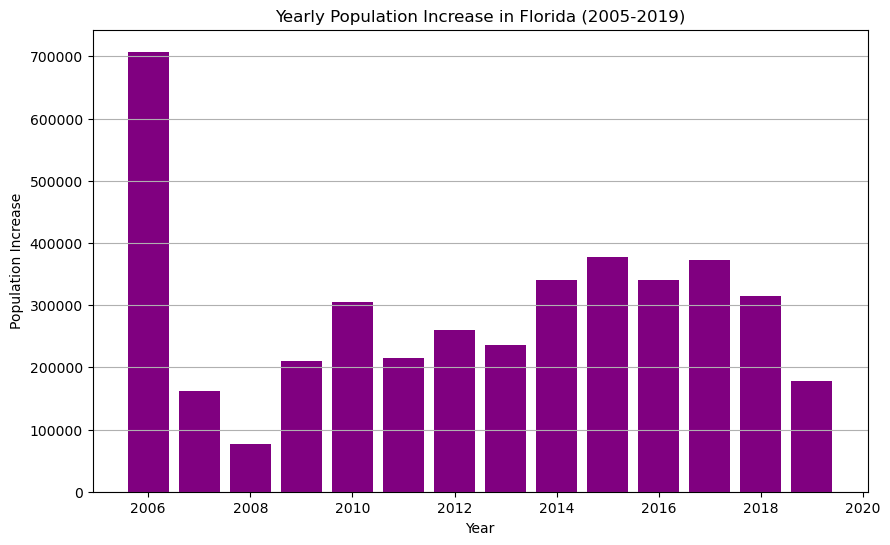

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(fl_growth_df['year'], fl_growth_df['population_increase'], color='purple')
plt.title("Yearly Population Increase in Florida (2005-2019)")
plt.xlabel("Year")
plt.ylabel("Population Increase")
plt.grid(axis='y')
plt.show()


Analyze the yearly population increase chart for Florida in {fl_growth_df} and summarize the trends, highlighting which years had the largest increases or decreases.

In [60]:
%%ai gpt4
Analyze the yearly population increase chart for Florida using the data in {fl_growth_df}.
Explain trends, identify the year with the largest population increase, and note any periods of slower growth.


The dataset presents the yearly population increase of Florida from 2005 to 2019. The population raise has been consistent during this period, rising from 17,382,511 in 2005 to 21,477,737 in 2019, accounting for an increase of about 4 million people during these 15 years.

In terms of annual increase, the highest jump is seen in 2015, with a significant increase of 377,975 people from the previous year. This is followed closely by the year 2017, which witnessed a population increase of 371,961. 

The period 2014 to 2017 is marked by higher growth rates compare to other periods. Specifically, each year in this period saw an increase of over 300,000 people. 

On the other hand, the smallest annual increase in population occurred in 2008, with only 77,097 additional people compared to the previous year. This period seems to represent a slower growth phase. Interestingly, despite the continuous growth, the year 2019 also saw a relatively small increase compared to previous years, with an increase of 178,412 individuals, marking it as a period of slower growth.

In summary, over the 15-year period, Florida's population has been consistently increasing. The years 2014-2017 have been particularly robust in terms of growth, while 2008 and 2019 saw relatively slower growth rates.

**Q3 Answer:** Florida's population consistently increased from 2005 to 2019, with the fastest growth occurring between 2014-2017 and the slowest in 2008 and 2019.